In [1]:
import numpy as np
from scipy.special import jv
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def unitary_met1(k:float, hbar:float, basis_size:int) -> np.ndarray :
    """Returns unitary operator of QKR"""
    U = np.zeros((basis_size, basis_size), dtype=complex)
    for (m,n), _ in np.ndenumerate(U):
        U[m,n] = np.exp(-1j*hbar*(m - basis_size//2)**2/2)*pow(1j, m-n)*jv(m-n, k/hbar)
        
    return U 

def unitary_met2(k:float, hbar:float, basis_size:int) -> np.ndarray :
    """Returns unitary operator of QKR"""
    U = np.zeros((basis_size, basis_size), dtype=complex)
    for (m,n), _ in np.ndenumerate(U):
        if abs(m-n) <= 2*k:
            U[m,n] = np.exp(-1j*hbar*(m - basis_size//2)**2/2)*pow(1j, m-n)*jv(m-n, k/hbar)
        else:
            U[m,n] = 0
        
    return U     

def unitary_k(k:float)-> np.ndarray :
    hbar=4*np.pi; basis_size=1024
    """Returns unitary operator of QKR"""
    U = np.zeros((basis_size, basis_size), dtype=complex)
    for (m,n), _ in np.ndenumerate(U):
        U[m,n] = np.exp(-1j*hbar*(m - basis_size//2)**2/2)*pow(1j, m-n)*jv(m-n, k/hbar)
        
    return U   


def decorate_plot(ax):
    sns.set_theme(style="ticks")
    ax.minorticks_on()
    ax.tick_params(direction="in", right=True, top=True)
    ax.tick_params(labelsize=18)
    ax.tick_params(labelbottom=True, labeltop=False, labelright=False)
    ax.tick_params(direction="in", which="minor", length=5, bottom=True)
    ax.tick_params(direction="in", which="major", length=10, bottom=True)
    ax.grid()
    return ax

In [3]:
import multiprocessing as mp
print("Total number of processors on your machine is:", mp.cpu_count())

Total number of processors on your machine is: 48


# First detection time distribtution


We solve the first detection time problem for quantum dynamics with a single detection site, which we label x = 0, so $|D = |0\rangle\langle0|$. We define the amplitude of the first detection as $\phi_n = \langle 0 | \theta_n \rangle$ and $F_n = |\phi_n|^2$. Using induction, it can bbe shown that: 

$$\phi_n = \langle 0 | U(n\tau) | 0 \rangle - \sum_{j=1}^{n-1} \phi_j \langle 0 | U[(n-j)\tau] | 0 \rangle $$

# Comparing Unitaries from two different methods

<AxesSubplot:>

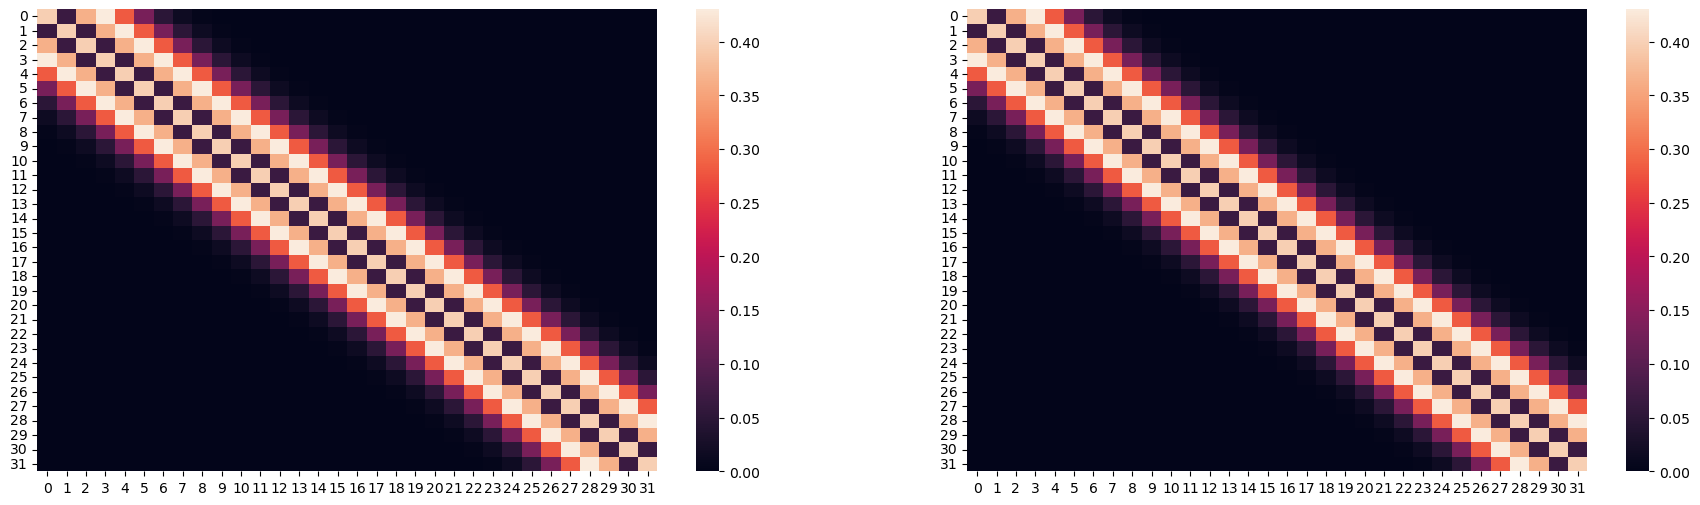

In [4]:
fig, ax = plt.subplots(1,2, figsize=(22,6))

sns.heatmap(np.abs(unitary_met1(4, 1, pow(2,5))), ax=ax[0])
sns.heatmap(np.abs(unitary_met2(4, 1, pow(2,5))), ax=ax[1])

In [5]:
k_mu = 3
hbar1 = 1.5
hbar2 = 0.5
basis = pow(2,9); print("Basis size:",basis)
time = 100

Basis size: 512


# Noisy evolution

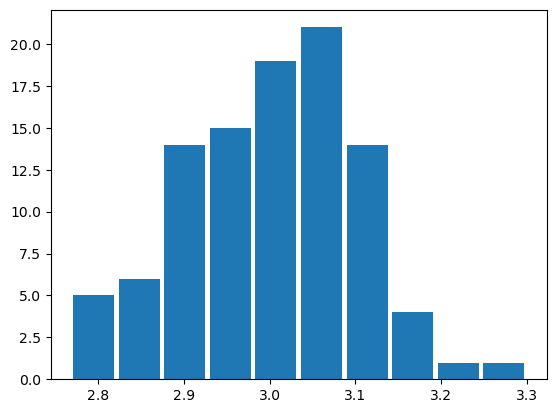

In [6]:
sigma = 1e-01
timesteps = 100

kappa = np.random.randn(timesteps)*sigma + k_mu
plt.hist(kappa, rwidth=0.9)
plt.show()

In [7]:
%%time 
U_noisy = [unitary_met2(k, hbar=1, basis_size=basis) for k in kappa]

CPU times: user 47 s, sys: 204 ms, total: 47.2 s
Wall time: 47.2 s


In [8]:
U_noisy[1].shape

(512, 512)

In [9]:
%%time

noisy_unitaries = np.zeros((basis, basis, timesteps), dtype=complex)
noisy_unitaries[:,:,0] = U_noisy[0]

for idx in range(1,len(U_noisy)):
    noisy_unitaries[:,:,idx] = noisy_unitaries[:,:, idx-1] @ U_noisy[idx]

CPU times: user 1min 30s, sys: 203 ms, total: 1min 30s
Wall time: 1min 30s


In [10]:
ket = np.zeros(basis)
ket[basis//2] = 1

/home/anantha/miniconda3/envs/sem8proj/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


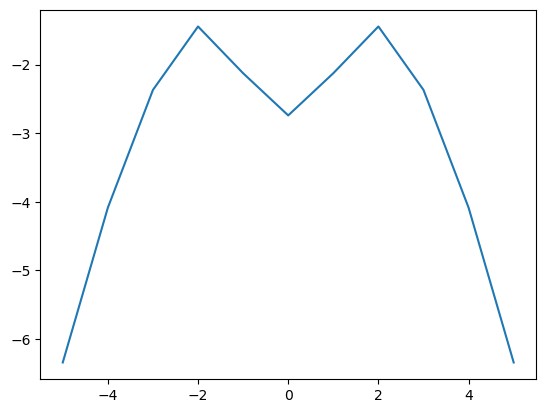

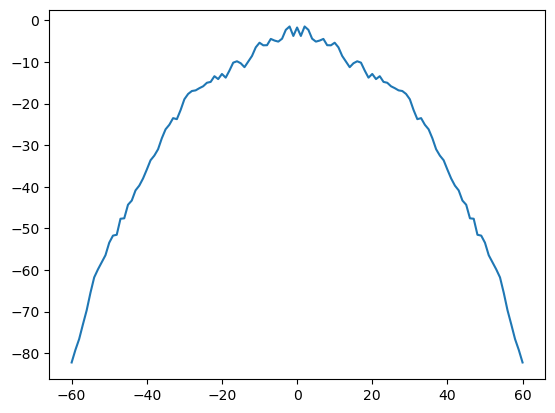

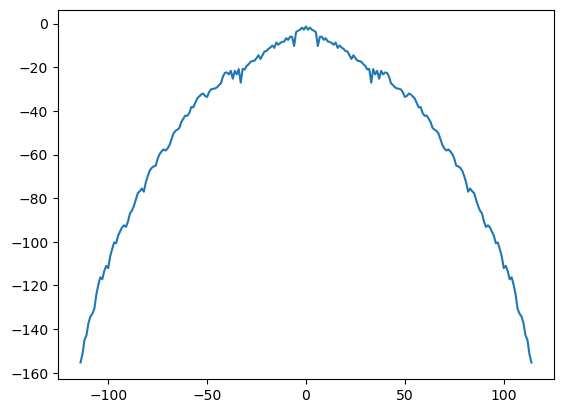

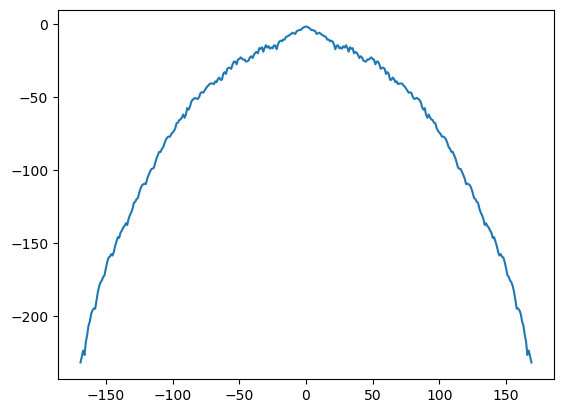

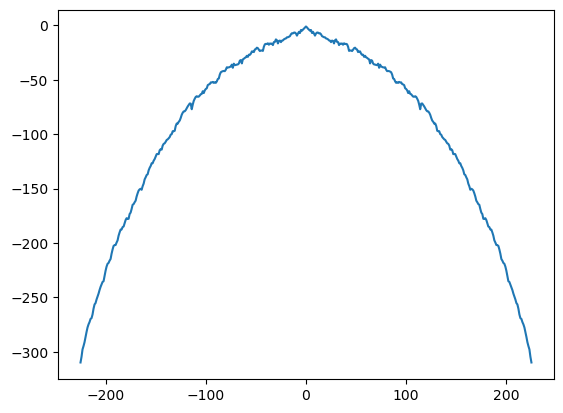

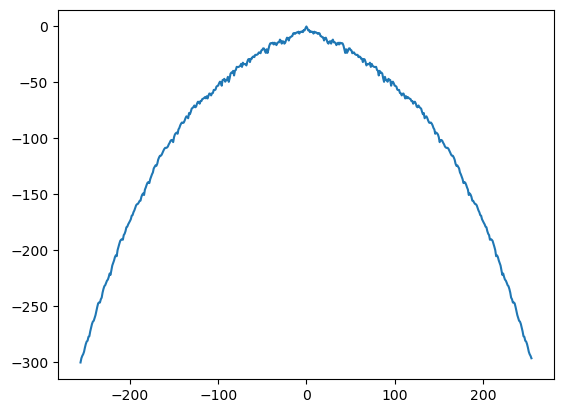

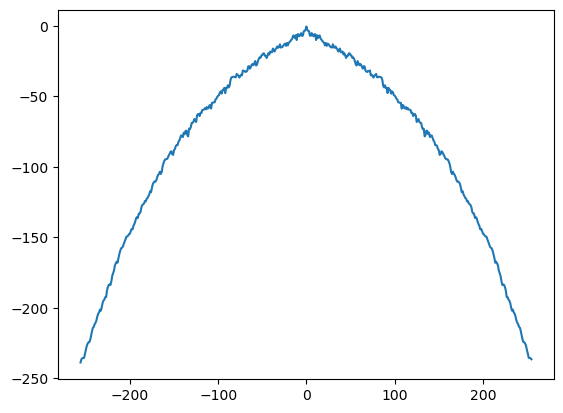

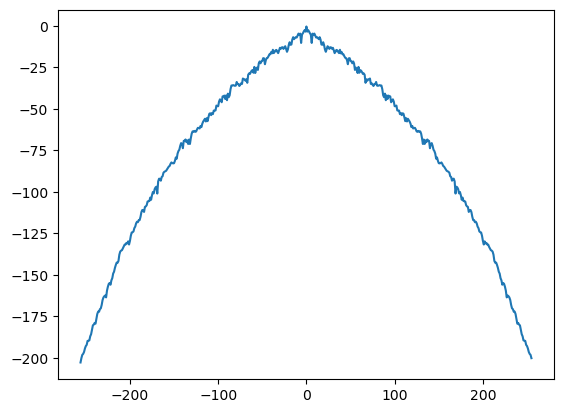

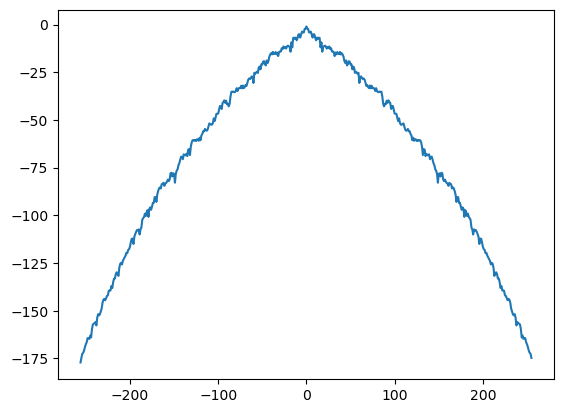

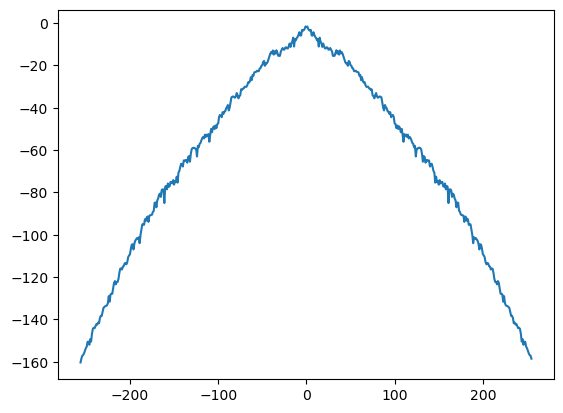

In [11]:
for i in range(0,timesteps,10):
    plt.plot(np.arange(-basis//2, basis//2), np.log(np.abs(noisy_unitaries[:,:,i] @ ket)**2))
    plt.show()

/home/anantha/miniconda3/envs/sem8proj/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


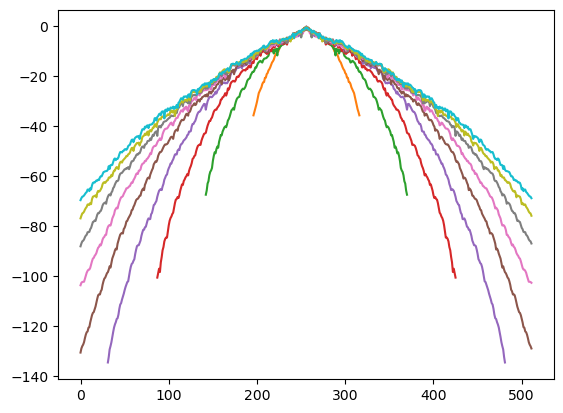

In [12]:
for i in range(0,timesteps,10):
    plt.plot(np.log10(np.abs(noisy_unitaries[:,:,i] @ ket)**2))

In [13]:
noisy_unitaries[:,:,0]

array([[-0.09476262+0.2357661j ,  0.32059439+0.12885807j,
        -0.18116902+0.45074222j, ...,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ],
       [-0.05423862-0.34123795j,  0.25094743-0.03988724j,
        -0.05423862-0.34123795j, ...,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ],
       [-0.48189897+0.06135258j,  0.04363757+0.34275491j,
        -0.25206301+0.0320912j , ...,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ],
       ...,
       [ 0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        , ...,  0.11624442-0.22594876j,
        -0.30724479-0.15806899j,  0.22223834-0.43197324j],
       [ 0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        , ...,  0.04363757+0.34275491j,
        -0.25206301+0.0320912j ,  0.04363757+0.34275491j],
       [ 0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j       

In [14]:
# FDTD of noisy evolution

psi_t = np.ones((timesteps), dtype=complex)

for i in range(0,timesteps):
    psi_t[i] = noisy_unitaries[basis//2, basis//2, i] - sum([noisy_unitaries[basis//2, basis//2, i - j] * psi_t[j] for j in range(i-1)])
    
f_t_noisy = np.abs(psi_t)**2

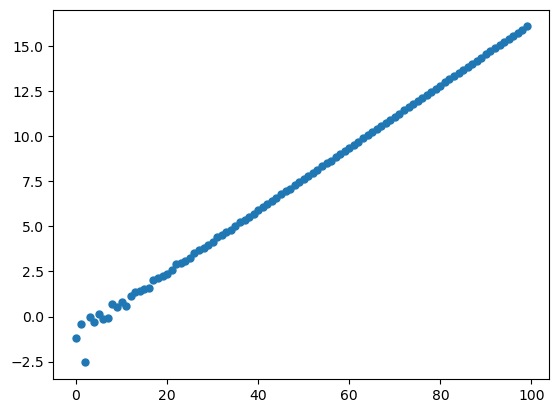

In [15]:
plt.plot(np.log10(f_t_noisy), 'o', markersize=5)

# Coherent dynamics

In [16]:
%time coherent_kicks = [k_mu]*timesteps

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 8.58 µs


In [17]:
# Compare cumulative unitaries with U(nk)

%time U_coherent = [unitary_met2(k, hbar=1, basis_size=basis) for k in coherent_kicks]

coherent_unitaries = np.zeros((basis, basis, timesteps), dtype=complex)
coherent_unitaries[:,:,0] = U_coherent[0]

for idx in range(1,len(U_coherent)):
    coherent_unitaries[:,:,idx] = coherent_unitaries[:,:, idx-1] @ U_coherent[idx]

CPU times: user 31.2 s, sys: 320 ms, total: 31.5 s
Wall time: 31.5 s


In [18]:
# FDTD of coherent evolution

psi_t_coh = np.ones((timesteps), dtype=complex)

for i in range(timesteps):
    psi_t_coh[i] = coherent_unitaries[basis//2, basis//2,i] - sum([coherent_unitaries[basis//2, basis//2, i-j] * psi_t_coh[j] for j in range(i)])
    
f_t_coherent = np.abs(psi_t_coh)**2

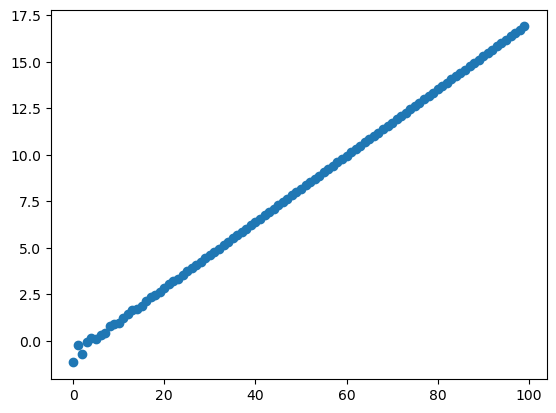

In [19]:
plt.plot(np.log10(f_t_coherent),'o')

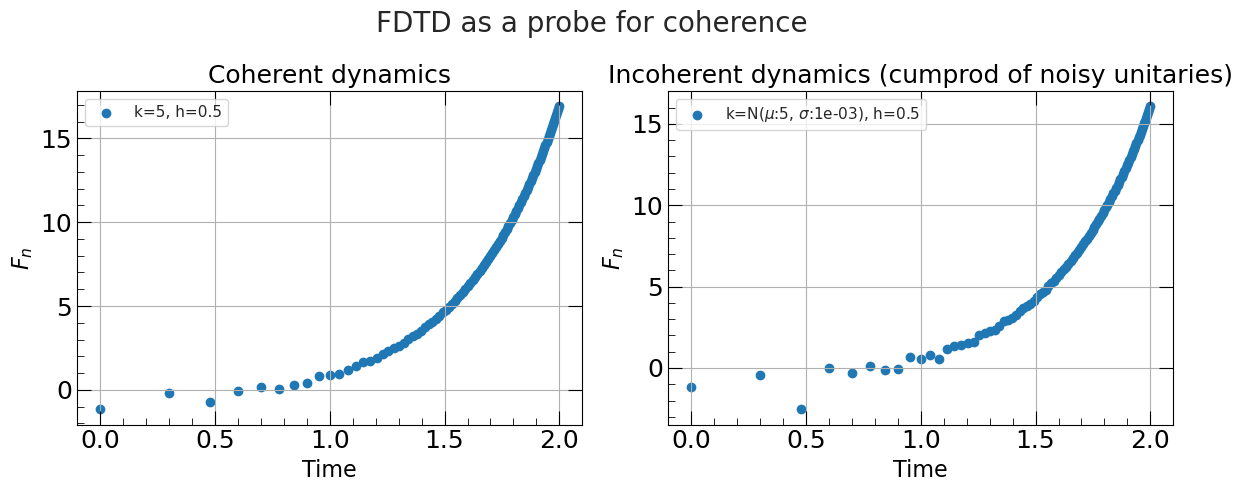

In [20]:
fig, axes = plt.subplots(1,2, figsize=(12,5))


    
axes[0].scatter(np.log10(np.arange(1,timesteps+1)), np.log10(f_t_coherent), label="k=5, h=0.5")

axes[1].scatter(np.log10(np.arange(1,timesteps+1)), np.log10(f_t_noisy), label="k=N($\mu$:5, $\sigma$:1e-03), h=0.5")


axes[0].set_title("Coherent dynamics", fontsize=18)
axes[1].set_title("Incoherent dynamics (cumprod of noisy unitaries)", fontsize=18)

# axes[0].set(xticks=[0,1,2], yticks=[-2,-5, -8])

# axes[1].set(xticks=[0,1,2]) #, yticks=[2,-1,-2])



# axes[0].set_yticklabels(["1e-02", "1e-05", "1e-08"])
# # axes[0].set_xticklabels([1, 10, 300])
# # #axes[1].set_yticklabels(["1", "1e-01", "1e-02"])
# # axes[1].set_xticklabels([1, 10, 100])

for ax in axes:
    decorate_plot(ax)
    ax.legend()
    ax.set_xlabel("Time", fontsize=16)
    ax.set_ylabel("$F_n$", fontsize=16)
    
plt.suptitle("FDTD as a probe for coherence", fontsize=20)
plt.tight_layout()
# plt.savefig("FDTD_dynamics_cumulative_product.png",
#            dpi=300, bbox_inches='tight')
plt.show()

[None, None]

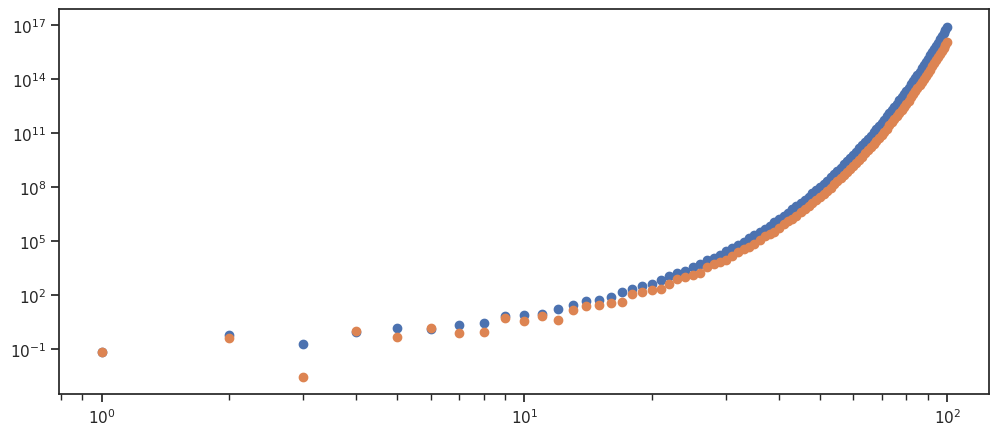

In [21]:
fig, axes = plt.subplots(1,1, figsize=(12,5))

axes.scatter(np.arange(1,timesteps+1), f_t_coherent, label="k=5, h=0.5")

axes.scatter(np.arange(1,timesteps+1), f_t_noisy, label="k=N($\mu$:5, $\sigma$:1e-03), h=0.5")

axes.set(yscale="log",xscale="log")
